In [1]:
%matplotlib inline
import functools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.special import expit
from jax.scipy.stats import bernoulli, gamma, norm
from sklearn.datasets import load_breast_cancer

from samplers import get_min_ess, make_samplers

# Basic setup

In [2]:
data = load_breast_cancer()
X = (data.data - np.mean(data.data, axis=0, keepdims=True)) / np.std(
    data.data, axis=0, keepdims=True
)
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
y = data.target

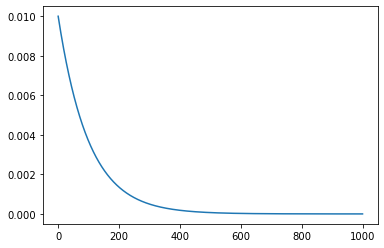

In [3]:
a = 1.0
beta = 0.01
ndim = X.shape[1]
x = np.linspace(0.01, 1000, int(1e5))
plt.plot(x, gamma.pdf(x, a, scale=1 / beta))


@jax.jit
def joint_energy(q_hmc, q_other):
    return (
        -gamma.logpdf(q_other, a, scale=1 / beta)
        - jnp.sum(norm.logpdf(q_hmc, scale=1 / jnp.sqrt(q_other)))
        - jnp.sum(bernoulli.logpmf(y, p=expit(jnp.dot(X, q_hmc))))
    )


@jax.jit
def sample_q_other(q_hmc, key):
    key, subkey = jax.random.split(key)
    q_other = jax.random.gamma(subkey, a + 0.5 * q_hmc.shape[0]) / (
        beta + 0.5 * jnp.sum(q_hmc ** 2)
    )
    return q_other, key


@jax.jit
def get_step_size(q_other, epsilon):
    return epsilon / jnp.sqrt(q_other)

In [4]:
(
    mala_within_gibbs,
    hmc_within_gibbs,
    mahmc_within_gibbs,
    mala_persistent_within_gibbs,
    mala_persistent_nonreversible_within_gibbs,
) = make_samplers(joint_energy, sample_q_other, get_step_size)

In [5]:
n_samples, n_warm_up_samples = int(1e5), int(1e4)
L = 5
n_chains = 1

# MALA within Gibbs

In [6]:
epsilon = 0.11


@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None), out_axes=0)
def get_mala_within_gibbs_samples(key, epsilon):
    def scan_f(carry, ii):
        beta, tau, key = carry
        beta, tau, key, accept = mala_within_gibbs(beta, tau, key, epsilon, L)
        energy = joint_energy(beta, tau)
        return (beta, tau, key), (beta, tau, energy, accept)

    tau = 150.0
    key, subkey = jax.random.split(key)
    beta = jax.random.normal(subkey, shape=(ndim,)) / jnp.sqrt(tau)
    _, samples = jax.lax.scan(scan_f, (beta, tau, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_mala_within_gibbs_samples(keys, epsilon)
print(
    f"""
### MALA-within-Gibbs, epsilon: {epsilon}

energies_ess: {get_min_ess(samples[2][..., None].copy())}
acceptance: {np.mean(samples[3])}
accuracy: {
    np.sum(
        y == (
            np.mean(
                expit(jnp.dot(samples[0][0], X.T)) >= 0.5,
                axis=0
            ) >= 0.5
        ).astype(int)
    ) / y.shape[0]
}

"""
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]



### MALA-within-Gibbs, epsilon: 0.11

energies_ess: 0.006790891102627784
acceptance: 0.8209933638572693
accuracy: 0.9876977205276489




# HMC-within-Gibbs

In [7]:
N = 2
epsilon = 0.09


@functools.partial(jax.jit, static_argnames="N")
@functools.partial(jax.vmap, in_axes=(0, None, None), out_axes=0)
def get_hmc_within_gibbs_samples(key, N, epsilon):
    def scan_f(carry, ii):
        beta, tau, key = carry
        beta, tau, key, accept = hmc_within_gibbs(beta, tau, key, epsilon, L * N)
        energy = joint_energy(beta, tau)
        return (beta, tau, key), (beta, tau, energy, accept)

    tau = 150.0
    key, subkey = jax.random.split(key)
    beta = jax.random.normal(subkey, shape=(ndim,)) / jnp.sqrt(tau)
    _, samples = jax.lax.scan(scan_f, (beta, tau, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_hmc_within_gibbs_samples(keys, N, epsilon)
print(
    f"""
### HMC-within-Gibbs, N: {N}, epsilon: {epsilon}

energies_ess: {get_min_ess(samples[2][..., None].copy()) / N}
acceptance: {np.mean(samples[3])}
accuracy: {
    np.sum(
        y == (
            np.mean(
                expit(jnp.dot(samples[0][0], X.T)) >= 0.5,
                axis=0
            ) >= 0.5
        ).astype(int)
    ) / y.shape[0]
}

"""
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]



### HMC-within-Gibbs, N: 2, epsilon: 0.09

energies_ess: 0.03945755561291712
acceptance: 0.881588876247406
accuracy: 0.9876977205276489




# MAHMC

In [8]:
N = 2
epsilon = 0.10


@functools.partial(jax.jit, static_argnames="N")
@functools.partial(jax.vmap, in_axes=(0, None, None), out_axes=0)
def get_mahmc_within_gibbs_samples(key, N, epsilon):
    def scan_f(carry, ii):
        beta, tau, key = carry
        beta, tau, key, accept = mahmc_within_gibbs(beta, tau, key, epsilon, L, N)
        energy = joint_energy(beta, tau)
        return (beta, tau, key), (beta, tau, energy, accept)

    tau = 150.0
    key, subkey = jax.random.split(key)
    beta = jax.random.normal(subkey, shape=(ndim,)) / jnp.sqrt(tau)
    _, samples = jax.lax.scan(scan_f, (beta, tau, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_mahmc_within_gibbs_samples(keys, N, epsilon)
accuracy = (
    np.sum(
        y
        == (np.mean(expit(jnp.dot(samples[0][0], X.T)) >= 0.5, axis=0) >= 0.5).astype(
            int
        )
    )
    / y.shape[0]
)
print(
    f"""
### MAHMC-within-Gibbs, N: {N}, epsilon: {epsilon}

energies_ess: {get_min_ess(samples[2][..., None].copy()) / N}
acceptance: {np.mean(samples[3])}
accuracy: {
    np.sum(
        y == (
            np.mean(
                expit(jnp.dot(samples[0][0], X.T)) >= 0.5,
                axis=0
            ) >= 0.5
        ).astype(int)
    ) / y.shape[0]
}

"""
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]



### MAHMC-within-Gibbs, N: 2, epsilon: 0.1

energies_ess: 0.047817248469230286
acceptance: 0.8319000005722046
accuracy: 0.9876977205276489




# MALA with persistent momentum

In [9]:
epsilon = 0.09
alpha = 0.9


@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None, None), out_axes=0)
def get_mala_persistent_within_gibbs_samples(key, epsilon, alpha):
    def scan_f(carry, ii):
        beta, p, tau, key = carry
        beta, p, tau, key, accept = mala_persistent_within_gibbs(
            beta, p, tau, key, epsilon, L, alpha
        )
        energy = joint_energy(beta, tau)
        return (beta, p, tau, key), (beta, tau, energy, accept)

    tau = 150.0
    key, subkey = jax.random.split(key)
    beta = jax.random.normal(subkey, shape=(ndim,)) / jnp.sqrt(tau)
    key, subkey = jax.random.split(key)
    p = jax.random.normal(subkey, shape=beta.shape)
    _, samples = jax.lax.scan(scan_f, (beta, p, tau, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_mala_persistent_within_gibbs_samples(keys, epsilon, alpha)
print(
    f"""
### MALA-P-within-Gibbs, epsilon: {epsilon}, alpha: {alpha}

energies_ess: {get_min_ess(samples[2][..., None].copy())}
acceptance: {np.mean(samples[3])}
accuracy: {
    np.sum(
        y == (
            np.mean(
                expit(jnp.dot(samples[0][0], X.T)) >= 0.5,
                axis=0
            ) >= 0.5
        ).astype(int)
    ) / y.shape[0]
}

"""
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7371.36it/s]



### MALA-P-within-Gibbs, epsilon: 0.09, alpha: 0.9

energies_ess: 0.03631890030070464
acceptance: 0.9016111493110657
accuracy: 0.9876977205276489




# MALA with persistent momentum and non-reversible Metropolis accept/reject

In [10]:
epsilon = 0.1
alpha = 0.9
delta = 0.015


@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None, None, None), out_axes=0)
def get_mala_persistent_nonreversible_within_gibbs_samples(key, epsilon, alpha, delta):
    def scan_f(carry, ii):
        beta, p, tau, v, key = carry
        beta, p, tau, v, key, accept = mala_persistent_nonreversible_within_gibbs(
            beta, p, tau, v, key, epsilon, L, alpha, delta
        )
        energy = joint_energy(beta, tau)
        return (beta, p, tau, v, key), (beta, tau, energy, accept)

    tau = 150.0
    key, subkey = jax.random.split(key)
    beta = jax.random.normal(subkey, shape=(ndim,)) / jnp.sqrt(tau)
    key, subkey = jax.random.split(key)
    p = jax.random.normal(subkey, shape=beta.shape)
    key, subkey = jax.random.split(key)
    v = jax.random.uniform(subkey) * 2 - 1
    _, samples = jax.lax.scan(scan_f, (beta, p, tau, v, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_mala_persistent_nonreversible_within_gibbs_samples(
    keys, epsilon, alpha, delta
)
print(
    f"""
### MALA-P-N-within-Gibbs, epsilon: {epsilon}, alpha: {alpha}, delta: {delta}

energies_ess: {get_min_ess(samples[2][..., None].copy())}
acceptance: {np.mean(samples[3])}
accuracy: {
    np.sum(
        y == (
            np.mean(
                expit(jnp.dot(samples[0][0], X.T)) >= 0.5,
                axis=0
            ) >= 0.5
        ).astype(int)
    ) / y.shape[0]
}

"""
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6864.65it/s]



### MALA-P-N-within-Gibbs, epsilon: 0.1, alpha: 0.9, delta: 0.015

energies_ess: 0.04087781447592402
acceptance: 0.8686622381210327
accuracy: 0.9876977205276489


